# Transforming images into csv

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import csv
import cv2
from ocr.normalization import letterNorm
from ocr.datahelpers import correspondingShuffle
# Helper functions - ploting and resizing
from ocr.helpers import implt, resize

In [3]:
def createDataCSV(dataloc, lang):
    """ Create images and labels CSV file for given data """
    print("Creating " + lang + " dataset")
    # Get subfolders with images
    dirlist = glob.glob(dataloc + lang + "/*/")
    dirlist.sort()
    # Name[17] should correspond to the letter (labels)
    chars = [name[17] for name in dirlist]

    images = np.zeros((1, 4096))
    labels = []

    # For every label load images and create corresponding labels
    # cv2.imread(img, 0) - for loading images in grayscale
    # Images are scaled to 64x64 = 4096 px
    for i in range(len(chars)):
        imglist = glob.glob(dirlist[i] + '*.jpg')
        imgs = np.array([letterNorm(cv2.imread(img, 0)) for img in imglist])
        images = np.concatenate([images, imgs.reshape(len(imgs), 4096)])
        labels.extend([i] * len(imgs))

    images = images[1:]
    labels = np.array(labels)

    assert len(labels) == len(images) # Check the same lenght of labels and images
    print("Images: %d" % len(labels))
    print("For %d different labels" % len(chars))

    images, labels = correspondingShuffle([images, labels])    

    # Create CSV files
    with open(dataloc + lang + '-data.csv', 'w') as csvfile:
        writer = csv.writer(csvfile, delimiter=',', quotechar='|', quoting=csv.QUOTE_MINIMAL)
        for row in images:
            writer.writerow(row)

    with open(dataloc + lang + '-labels.csv', 'w') as csvfile:
        writer = csv.writer(csvfile, delimiter=',', quotechar='|', quoting=csv.QUOTE_MINIMAL)
        writer.writerow(labels)

    # Print one of the images (last one)
    implt(images[-1].reshape(64,64), 'gray', 'Example')
    print("CSV data files saved.\n")

Creating cz dataset
Images: 2613
For 83 different labels


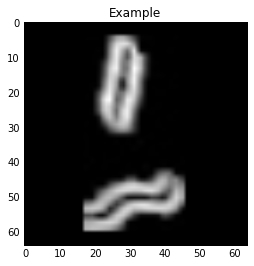

CSV data files saved.

Creating en dataset
Images: 2607
For 53 different labels


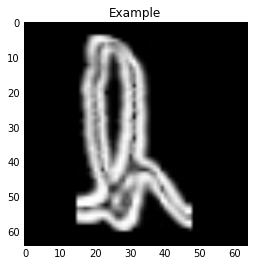

CSV data files saved.



In [4]:
LANG_CZ = 'cz'
LANG_EN = 'en'
DATA_LOC = 'data/charclas/'

# Run creating for both CZ and EN dataset
createDataCSV(DATA_LOC, LANG_CZ)
createDataCSV(DATA_LOC, LANG_EN)